In [34]:
!pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.2.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [35]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque, defaultdict
import time
import heapq
import math


In [37]:
N = 20  # grid size: 8x8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def random_grid(p_block=0.2):
    """
    Returns an NxN grid:
      0 = free cell
      1 = blocked cell
    """
    grid = [[0 for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            if random.random() < p_block:
                grid[i][j] = 1
    return grid

def random_start_goal(grid):
    """
    Pick two different free cells as (start, goal).
    Returns (start, goal) or (None, None) if not possible.
    """
    free_cells = [(i, j) for i in range(N) for j in range(N) if grid[i][j] == 0]
    if len(free_cells) < 2:
        return None, None
    start = random.choice(free_cells)
    remaining = [c for c in free_cells if c != start]
    goal = random.choice(remaining)
    return start, goal

def neighbors(i, j):
    """
    4-neighborhood (up, down, left, right).
    """
    for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < N and 0 <= nj < N:
            yield ni, nj

def bfs_shortest_path(grid, start, goal):
    """
    Breadth-first search for shortest path on an unweighted grid.
    Returns list of (i, j) cells from start to goal, or None if no path.
    """
    queue = deque()
    queue.append(start)
    came_from = {start: None}

    while queue:
        cur = queue.popleft()
        if cur == goal:
            # reconstruct path
            path = []
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path

        i, j = cur
        for ni, nj in neighbors(i, j):
            if grid[ni][nj] == 1:  # blocked
                continue
            nxt = (ni, nj)
            if nxt not in came_from:
                came_from[nxt] = cur
                queue.append(nxt)

    return None  # no path

def astar_shortest_path(grid, start, goal):
    """
    A* search for shortest path on an unweighted grid.
    Returns list of (i, j) cells from start to goal, or None if no path.
    Heuristic: Manhattan distance.
    """
    def h(cell):
        return abs(cell[0] - goal[0]) + abs(cell[1] - goal[1])

    open_heap = []
    heapq.heappush(open_heap, (h(start), 0, start))  # (f, g, node)

    came_from = {start: None}
    g_score = {start: 0}

    while open_heap:
        _, g, cur = heapq.heappop(open_heap)

        if cur == goal:
            # reconstruct
            path = []
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path

        i, j = cur
        for ni, nj in neighbors(i, j):
            if grid[ni][nj] == 1:
                continue

            nxt = (ni, nj)
            tentative_g = g + 1

            if nxt not in g_score or tentative_g < g_score[nxt]:
                g_score[nxt] = tentative_g
                came_from[nxt] = cur
                f = tentative_g + h(nxt)
                heapq.heappush(open_heap, (f, tentative_g, nxt))

    return None



baseline_test

In [38]:
# -------------------------------
# Reproducibility + Run Info
# -------------------------------
import platform, torch, numpy as np, random, time
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

RUN_INFO = {
    "seed": SEED,
    "grid_N": N,
    "p_block_train": 0.2,          # matches your generator in the PDF
    "teacher": "A*",               # dataset created using astar_shortest_path in generate_dataset
    "device": str(device),
    "torch": torch.__version__,
    "numpy": np.__version__,
    "timestamp_utc": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()),
}
print(RUN_INFO)


{'seed': 42, 'grid_N': 20, 'p_block_train': 0.2, 'teacher': 'A*', 'device': 'cuda', 'torch': '2.2.0+cu118', 'numpy': '1.26.4', 'timestamp_utc': '2026-01-31 12:15:00'}


In [39]:
def cell_to_index(i, j):
    """
    Maps (i, j) in the grid to a node index in [0, N*N-1].
    """
    return i * N + j


In [40]:
def grid_to_graph(grid, start, goal, path):
    num_nodes = N * N

    # Node features (8):
    # [is_blocked, is_start, is_goal, x_norm, y_norm,
    #  manhattan_to_goal_norm, manhattan_to_start_norm, euclid_to_goal_norm]
    x = torch.zeros((num_nodes, 8), dtype=torch.float)
    y = torch.zeros(num_nodes, dtype=torch.float)

    path_set = set(path) if path is not None else set()

    start_i, start_j = start
    goal_i, goal_j = goal

    # ---- node features + labels ----
    for i in range(N):
        for j in range(N):
            idx = cell_to_index(i, j)

            is_blocked = float(grid[i][j] == 1)
            is_start   = float((i, j) == start)
            is_goal    = float((i, j) == goal)

            x_norm = i / (N - 1)
            y_norm = j / (N - 1)

            man_goal = abs(i - goal_i) + abs(j - goal_j)
            man_start = abs(i - start_i) + abs(j - start_j)
            man_goal_norm = man_goal / (2 * (N - 1))
            man_start_norm = man_start / (2 * (N - 1))

            euclid = ((i - goal_i)**2 + (j - goal_j)**2) ** 0.5
            euclid_norm = euclid / ((2 * (N - 1)) ** 0.5)

            x[idx] = torch.tensor([
                is_blocked, is_start, is_goal,
                x_norm, y_norm,
                man_goal_norm, man_start_norm, euclid_norm
            ], dtype=torch.float)

            # soft labels: 1.0 on path, 0.3 if within 1 step of path, else 0.0
            if (i, j) in path_set:
                y[idx] = 1.0
            else:
                # check if any neighbor is on path
                near = False
                for ni, nj in neighbors(i, j):
                    if (ni, nj) in path_set:
                        near = True
                        break
                y[idx] = 0.3 if near else 0.0

    # ---- edges only between FREE cells ----
    edge_index_list = []
    for i in range(N):
        for j in range(N):
            if grid[i][j] == 1:
                continue
            idx = cell_to_index(i, j)
            for ni, nj in neighbors(i, j):
                if grid[ni][nj] == 1:
                    continue
                nidx = cell_to_index(ni, nj)
                edge_index_list.append([idx, nidx])

    if not edge_index_list:
        return None

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index, y=y)


In [41]:
def generate_dataset(num_samples=1200, p_block=0.2):
    data_list = []
    for _ in range(num_samples):
        grid = random_grid(p_block=p_block)
        start, goal = random_start_goal(grid)
        if start is None or goal is None:
            continue
        path = astar_shortest_path(grid, start, goal)
        if path is None:
            continue
        data = grid_to_graph(grid, start, goal, path)
        if data is not None:
            data_list.append(data)
    return data_list

print("Dataset size:", len(dataset))

print("Example x shape:", dataset[0].x.shape)  # should be [N*N, 8]
print("Example y shape:", dataset[0].y.shape)  # should be [N*N]



Dataset size: 1179
Example x shape: torch.Size([400, 8])
Example y shape: torch.Size([400])


In [42]:
random.shuffle(dataset)
n = len(dataset)
train_data = dataset[:int(0.7 * n)]
val_data   = dataset[int(0.7 * n):int(0.85 * n)]
test_data  = dataset[int(0.85 * n):]

# pos_weight = compute_pos_weight(train_data).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# print("pos_weight:", float(pos_weight.item()))

# Explicitly ensure all data is on CPU for DataLoaders
train_data = [d.to('cpu') for d in train_data]
val_data = [d.to('cpu') for d in val_data]
test_data = [d.to('cpu') for d in test_data]

len(train_data), len(val_data), len(test_data)

(825, 177, 177)

In [43]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=False)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=False)

In [44]:
from torch_geometric.nn import SAGEConv

class SAGEPathPredictor(nn.Module):
    def __init__(self, in_channels, hidden_dim=128, dropout=0.2, num_layers=5):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.lin = nn.Linear(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.lin(x).squeeze(-1)


In [45]:
print("Using device:", device)

model = SAGEPathPredictor(in_channels=8, hidden_dim=128, dropout=0.2, num_layers=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cuda


In [46]:
def compute_pos_weight(dataset):
    """
    Compute pos_weight over FREE cells only, using HARD labels:
      pos = y == 1.0
      neg = y == 0.0
    Ignore y==0.3 "near-path" soft labels so the ratio is stable.
    """
    pos, neg = 0, 0
    for d in dataset:
        free_mask = (d.x[:, 0] == 0)  # is_blocked == 0
        y = d.y[free_mask]
        pos += (y == 1.0).sum().item()
        neg += (y == 0.0).sum().item()
    return torch.tensor([neg / (pos + 1e-8)], dtype=torch.float)


In [47]:
# -------------------------------
# Loss function (GLOBAL)
# -------------------------------
pos_weight = compute_pos_weight(train_data).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("pos_weight:", float(pos_weight.item()))


pos_weight: 18.024450302124023


In [48]:
def _prf_from_preds(y_true, y_pred):
    tp = ((y_pred == 1) & (y_true == 1)).sum().item()
    fp = ((y_pred == 1) & (y_true == 0)).sum().item()
    fn = ((y_pred == 0) & (y_true == 1)).sum().item()
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

def train_one_epoch(threshold=0.5):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index)

        free_mask = (batch.x[:, 0] == 0)  # is_blocked == 0
        loss = criterion(logits[free_mask], batch.y[free_mask])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [49]:
@torch.no_grad()
def evaluate(loader, threshold=0.5):
    model.eval()
    total_loss = 0.0

    all_y = []
    all_pred = []

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)

        free_mask = (batch.x[:, 0] == 0)
        loss = criterion(logits[free_mask], batch.y[free_mask])
        total_loss += loss.item()

        probs = torch.sigmoid(logits[free_mask])
        preds = (probs > threshold).float()

        all_y.append(batch.y[free_mask].detach().cpu())
        all_pred.append(preds.detach().cpu())

    y_true_soft = torch.cat(all_y)
    y_pred = torch.cat(all_pred)

    # ✅ Convert soft labels to hard labels for metrics
    y_true = (y_true_soft >= 0.5).float()

    accuracy = (y_true == y_pred).float().mean().item()
    precision, recall, f1 = _prf_from_preds(y_true, y_pred)

    return (total_loss / len(loader)), accuracy, precision, recall, f1


In [50]:
num_epochs = 60

train_losses = []
val_losses = []
val_f1s = []

threshold = 0.5  # we will tune later

for epoch in range(1, num_epochs + 1):
    tr_loss = train_one_epoch(threshold=threshold)
    va_loss, va_acc, va_prec, va_rec, va_f1 = evaluate(val_loader, threshold=threshold)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_f1s.append(va_f1)

    print(f"Epoch {epoch:02d} | TrainLoss {tr_loss:.4f} | ValLoss {va_loss:.4f} | "
          f"ValAcc {va_acc:.4f} | ValP {va_prec:.3f} | ValR {va_rec:.3f} | ValF1 {va_f1:.3f}")


Epoch 01 | TrainLoss 1.3037 | ValLoss 1.0500 | ValAcc 0.6022 | ValP 0.099 | ValR 0.890 | ValF1 0.177
Epoch 02 | TrainLoss 1.0870 | ValLoss 1.0435 | ValAcc 0.7513 | ValP 0.136 | ValR 0.777 | ValF1 0.231
Epoch 03 | TrainLoss 1.0194 | ValLoss 0.9710 | ValAcc 0.6495 | ValP 0.111 | ValR 0.895 | ValF1 0.197
Epoch 04 | TrainLoss 1.0064 | ValLoss 0.9830 | ValAcc 0.5726 | ValP 0.097 | ValR 0.945 | ValF1 0.176
Epoch 05 | TrainLoss 0.9772 | ValLoss 0.9485 | ValAcc 0.7055 | ValP 0.127 | ValR 0.870 | ValF1 0.222
Epoch 06 | TrainLoss 0.9813 | ValLoss 0.9366 | ValAcc 0.6976 | ValP 0.124 | ValR 0.873 | ValF1 0.218
Epoch 07 | TrainLoss 0.9412 | ValLoss 0.9314 | ValAcc 0.6867 | ValP 0.121 | ValR 0.878 | ValF1 0.213
Epoch 08 | TrainLoss 0.9428 | ValLoss 0.9278 | ValAcc 0.6081 | ValP 0.104 | ValR 0.936 | ValF1 0.187
Epoch 09 | TrainLoss 0.9415 | ValLoss 0.9122 | ValAcc 0.6720 | ValP 0.118 | ValR 0.899 | ValF1 0.209
Epoch 10 | TrainLoss 0.9353 | ValLoss 0.9207 | ValAcc 0.6085 | ValP 0.105 | ValR 0.943 | Va

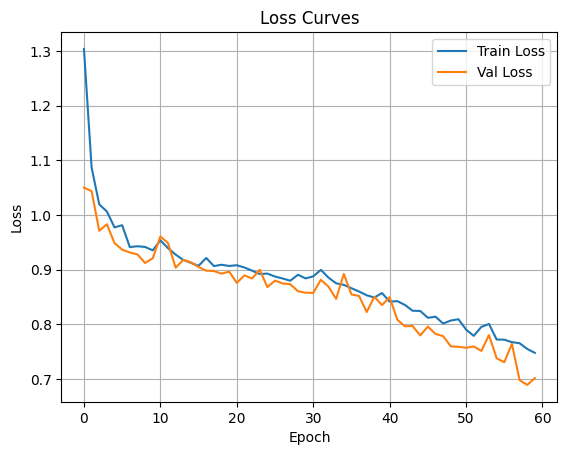

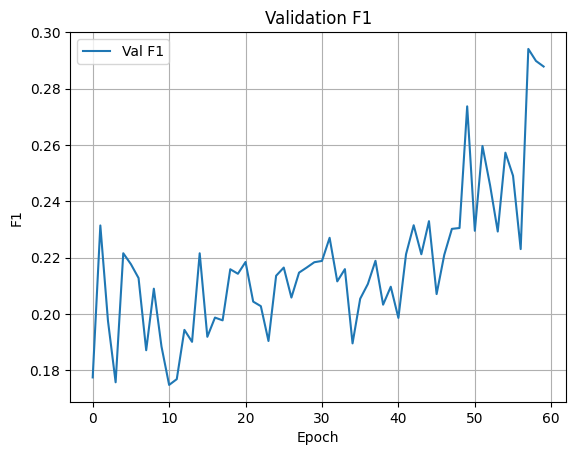

In [51]:

# plots
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.title("Validation F1")
plt.legend(); plt.grid(True); plt.show()

# plt.figure()
# plt.plot(val_accuracies, label="Val Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Validation Accuracy over Epochs")
# plt.legend()
# plt.grid(True)
# plt.show()



In [52]:
@torch.no_grad()
def best_threshold_on_val(loader, steps=101):
    """
    Finds threshold in [0,1] maximizing F1 on validation set.
    """
    best_t, best_f1 = 0.5, -1.0
    for k in range(steps):
        t = k / (steps - 1)
        _, _, _, _, f1 = evaluate(loader, threshold=t)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

t_star, f1_star = best_threshold_on_val(val_loader)
print("Best threshold:", t_star, "Best Val F1:", f1_star)


Best threshold: 0.86 Best Val F1: 0.43615590901147183


In [53]:
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader, threshold=t_star)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}")
print(f"Test Prec: {test_prec:.4f}")
print(f"Test Rec:  {test_rec:.4f}")
print(f"Test F1:   {test_f1:.4f}")


Test Loss: 0.6846
Test Acc:  0.9404
Test Prec: 0.3898
Test Rec:  0.4687
Test F1:   0.4256


In [54]:
import numpy as np

In [55]:
@torch.no_grad()
def visualize_sample(idx=0, threshold=0.5):
    data = test_data[idx]  # CPU
    model.eval()

    data_gpu = data.to(device)
    logits = model(data_gpu.x, data_gpu.edge_index)
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    # SAFE: no NumPy dependency
    y_true = data.y.cpu().tolist()
    y_pred = preds.cpu().tolist()
    x_features = data.x.cpu().tolist()

    is_blocked = [f[0] for f in x_features]
    is_start   = [f[1] for f in x_features]
    is_goal    = [f[2] for f in x_features]

    true_grid  = np.zeros((N, N))
    pred_grid  = np.zeros((N, N))
    block_grid = np.zeros((N, N))
    start_grid = np.zeros((N, N))
    goal_grid  = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            idx_node = cell_to_index(i, j)
            true_grid[i, j]  = y_true[idx_node]
            pred_grid[i, j]  = y_pred[idx_node]
            block_grid[i, j] = is_blocked[idx_node]
            start_grid[i, j] = is_start[idx_node]
            goal_grid[i, j]  = is_goal[idx_node]

    img = np.zeros((N, N, 3), dtype=float)
    img[:, :, :] = 0.9
    img[block_grid == 1] = [0.0, 0.0, 0.0]
    img[true_grid == 1]  = [0.3, 1.0, 0.3]

    pred_mask = (pred_grid == 1)
    img[pred_mask] = img[pred_mask] * 0.5 + np.array([0.3, 0.3, 1.0]) * 0.5

    img[start_grid == 1] = [1.0, 0.2, 0.2]
    img[goal_grid == 1]  = [0.7, 0.0, 0.0]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Green=True | Blue=Pred (t={threshold:.2f}) | Red=Start/Goal | Black=Obstacle")
    plt.axis("off")
    plt.show()


In [56]:
import numpy
print(f"Current NumPy version: {numpy.__version__}")

Current NumPy version: 1.26.4


The previous errors `RuntimeError: Numpy is not available` and `Failed to initialize NumPy` are due to an incompatibility between NumPy 2.x and the installed PyTorch version. To fix this, we need to downgrade NumPy to a 1.x version. After executing the next cell, **please restart the runtime** for the changes to take effect.

In [57]:
!pip install numpy==1.26.4

After restarting the runtime, you can re-run the `visualize_sample` and `plot_prob_histogram` cells.

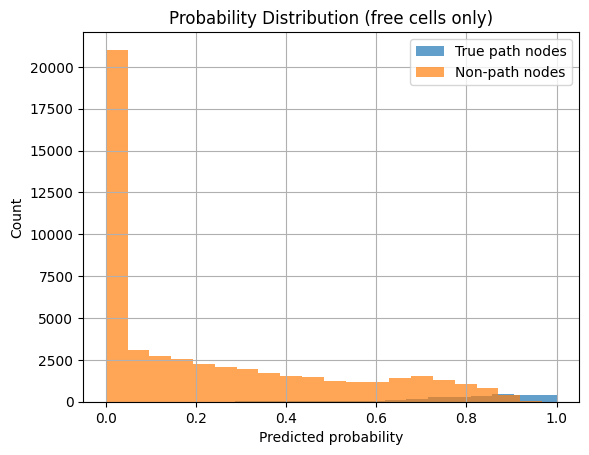


--- Planner Evaluation (test_data) ---
{'astar_success_rate': 1.0, 'greedy_success_rate': 1.0, 'neural_success_rate': 1.0, 'astar_avg_len': 14.090395480225988, 'greedy_avg_len': 16.570621468926554, 'neural_avg_len': 14.090395480225988, 'astar_avg_time_s': 0.00043561902825169487, 'greedy_avg_time_s': 0.0007808773050867985, 'neural_avg_time_s': 0.000799902768354041, 'greedy_len_ratio_vs_astar': 1.2949872065953565, 'neural_len_ratio_vs_astar': 1.0, 'astar_avg_expansions': 33.5819209039548, 'neural_avg_expansions': 29.10169491525424}


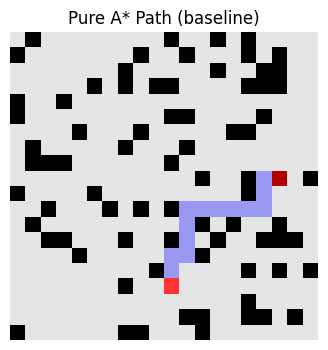

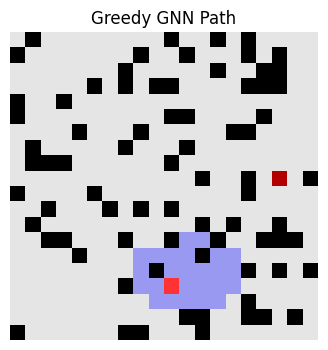

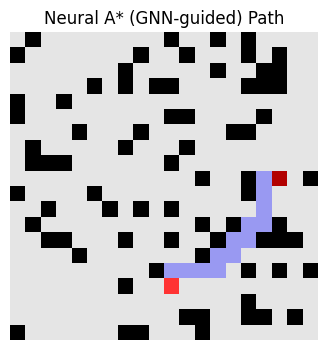

In [58]:
@torch.no_grad()
def plot_prob_histogram(loader):
    model.eval()
    all_probs = []
    all_labels = []

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)
        free_mask = (batch.x[:, 0] == 0)

        probs = torch.sigmoid(logits[free_mask]).detach().cpu().numpy()
        labels = batch.y[free_mask].detach().cpu().numpy()

        all_probs.extend(list(probs))
        all_labels.extend(list(labels))

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    plt.figure()
    plt.hist(all_probs[all_labels == 1], bins=20, alpha=0.7, label="True path nodes")
    plt.hist(all_probs[all_labels == 0], bins=20, alpha=0.7, label="Non-path nodes")
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.title("Probability Distribution (free cells only)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_prob_histogram(test_loader)
# ============================================================
# Phase 3: Inference & Path Reconstruction (NEXT STEP)
# ============================================================

def get_start_goal_from_data(data):
    """
    Extract start and goal node indices from node features.
    x[:,1] = is_start, x[:,2] = is_goal
    """
    x = data.x
    start_idx = int((x[:, 1] == 1).nonzero(as_tuple=False)[0].item())
    goal_idx  = int((x[:, 2] == 1).nonzero(as_tuple=False)[0].item())
    return start_idx, goal_idx

def build_adj_list(edge_index, num_nodes):
    """
    edge_index: [2, E]
    returns adjacency list: list[list[int]] where adj[u] = neighbors of u
    """
    adj = [[] for _ in range(num_nodes)]
    src = edge_index[0].tolist()
    dst = edge_index[1].tolist()
    for s, d in zip(src, dst):
        adj[s].append(d)
    return adj

from collections import deque
import math, heapq
import numpy as np

def bfs_path_graph(data):
    """BFS on the Data graph (unweighted). Returns (path, expansions) or (None, expansions)."""
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    q = deque([start])
    came = {start: None}
    expansions = 0

    while q:
        u = q.popleft()
        expansions += 1
        if u == goal:
            # reconstruct
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came[cur]
            path.reverse()
            return path, expansions
        for v in adj[u]:
            if v not in came:
                came[v] = u
                q.append(v)

    return None, expansions


def dijkstra_path_graph(data):
    """Dijkstra on the Data graph (unit weights here). Returns (path, expansions)."""
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    dist = {start: 0.0}
    came = {start: None}
    pq = [(0.0, start)]
    expansions = 0

    while pq:
        d, u = heapq.heappop(pq)
        expansions += 1
        if u == goal:
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came[cur]
            path.reverse()
            return path, expansions
        if d > dist.get(u, math.inf):
            continue
        for v in adj[u]:
            nd = d + 1.0
            if nd < dist.get(v, math.inf):
                dist[v] = nd
                came[v] = u
                heapq.heappush(pq, (nd, v))

    return None, expansions


# def random_walk_path(data, max_steps=400):
#     """Random baseline: random walk without revisiting if possible."""
#     start, goal = get_start_goal_from_data(data)
#     adj = build_adj_list(data.edge_index, data.num_nodes)
#     cur = start
#     path = [cur]
#     visited = {cur}

#     for _ in range(max_steps):
#         if cur == goal:
#             return path
#         candidates = [n for n in adj[cur] if n not in visited]
#         if not candidates:
#             # allow revisit if stuck
#             candidates = adj[cur]
#             if not candidates:
#                 return None
#         nxt = random.choice(candidates)
#         path.append(nxt)
#         visited.add(nxt)
#         cur = nxt
#     return None


def path_len_nodes(path):
    return (len(path) - 1) if path is not None else None


@torch.no_grad()
def predict_node_probs(data):
    """
    Runs GNN and returns per-node probabilities (CPU tensor shape [num_nodes]).
    """
    model.eval()
    data_gpu = data.to(device)
    logits = model(data_gpu.x, data_gpu.edge_index)
    probs = torch.sigmoid(logits).detach().cpu()
    return probs

def greedy_path(data, probs, max_steps=400):
    """
    Greedy reconstruction:
      start -> repeatedly choose neighbor with max prob until goal or stuck.
    Returns: list[node_idx] path or None
    """
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    current = start
    path = [current]
    visited = set([current])

    for _ in range(max_steps):
        if current == goal:
            return path

        candidates = [n for n in adj[current] if n not in visited]
        if not candidates:
            return path

        next_node = max(candidates, key=lambda n: float(probs[n]))
        visited.add(next_node)
        path.append(next_node)
        current = next_node

    return None

def manhattan_idx(a, b):
    """
    Manhattan distance on the NxN grid using node indices.
    """
    ax, ay = divmod(a, N)
    bx, by = divmod(b, N)
    return abs(ax - bx) + abs(ay - by)

def astar_path(data):
    """
    Pure A* on the same graph (no GNN).
    Uses Manhattan distance heuristic on the NxN grid indices.
    Returns: list[node_idx] path or None
    """
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    open_heap = []
    heapq.heappush(open_heap, (0.0, start))

    came_from = {start: None}
    g_score = defaultdict(lambda: math.inf)
    g_score[start] = 0.0

    expansions = 0

    while open_heap:
        _, current = heapq.heappop(open_heap)
        expansions += 1

        if current == goal:
            # reconstruct
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path, expansions

        for nb in adj[current]:
            tentative_g = g_score[current] + 1.0  # unit edge costs
            if tentative_g < g_score[nb]:
                came_from[nb] = current
                g_score[nb] = tentative_g

                h = manhattan_idx(nb, goal)
                f = tentative_g + h

                heapq.heappush(open_heap, (f, nb))

    return None, expansions


def neural_astar_path(data, probs, alpha=2.0):
    """
    Hybrid A* guided by GNN:
      f(n) = g(n) + h(n) + alpha*(1 - prob(n))
    Returns: list[node_idx] path or None
    """
    start, goal = get_start_goal_from_data(data)
    adj = build_adj_list(data.edge_index, data.num_nodes)

    open_heap = []
    heapq.heappush(open_heap, (0.0, start))

    came_from = {start: None}
    g_score = defaultdict(lambda: math.inf)
    g_score[start] = 0.0
    expansions = 0

    while open_heap:
        _, current = heapq.heappop(open_heap)
        expansions += 1

        if current == goal:
            # reconstruct
            path = []
            cur = goal
            while cur is not None:
                path.append(cur)
                cur = came_from[cur]
            path.reverse()
            return path, expansions

        for nb in adj[current]:
            tentative_g = g_score[current] + 1.0
            if tentative_g < g_score[nb]:
                came_from[nb] = current
                g_score[nb] = tentative_g

                h = manhattan_idx(nb, goal)
                bias = alpha * (1.0 - float(probs[nb]))
                f = tentative_g + h + bias

                heapq.heappush(open_heap, (f, nb))

    return None, expansions

def path_length(path):
    return (len(path) - 1) if path is not None else None

@torch.no_grad()
def evaluate_planners(dataset, alpha=2.0):
    """
    Runs:
      - Pure A*
      - Greedy-GNN
      - Neural A* (GNN-guided)
    Reports:
      - success rates
      - average path length (for successes)
      - average runtime
      - length ratios vs A*
      - expansions (A* nodes popped)
    """
    astar_success = 0
    greedy_success = 0
    neural_success = 0

    astar_lengths, greedy_lengths, neural_lengths = [], [], []
    astar_times, greedy_times, neural_times = [], [], []
    astar_expansions, neural_expansions = [], []

    greedy_len_ratios, neural_len_ratios = [], []

    for data in dataset:
        # ---------- Pure A* ----------
        t0 = time.perf_counter()
        apath, aexp = astar_path(data)
        t1 = time.perf_counter()
        astar_times.append(t1 - t0)
        astar_expansions.append(aexp)

        a_len = path_length(apath)
        if apath is not None:
            astar_success += 1
            astar_lengths.append(a_len)

        # ---------- GNN probs once ----------
        probs = predict_node_probs(data)

        # ---------- Greedy ----------
        t0 = time.perf_counter()
        gpath = greedy_path(data, probs)
        t1 = time.perf_counter()
        greedy_times.append(t1 - t0)

        g_len = path_length(gpath)
        if gpath is not None:
            greedy_success += 1
            greedy_lengths.append(g_len)

        # ---------- Neural A* ----------
        t0 = time.perf_counter()
        npath, nexp = neural_astar_path(data, probs, alpha=alpha)
        t1 = time.perf_counter()
        neural_times.append(t1 - t0)
        neural_expansions.append(nexp)

        n_len = path_length(npath)
        if npath is not None:
            neural_success += 1
            neural_lengths.append(n_len)

        # ---------- Ratios vs A* ----------
        if apath is not None and a_len is not None and a_len > 0:
            if gpath is not None and g_len is not None:
                greedy_len_ratios.append(g_len / a_len)
            if npath is not None and n_len is not None:
                neural_len_ratios.append(n_len / a_len)

    results = {
        "astar_success_rate": astar_success / len(dataset),
        "greedy_success_rate": greedy_success / len(dataset),
        "neural_success_rate": neural_success / len(dataset),

        "astar_avg_len": float(np.mean(astar_lengths)) if astar_lengths else None,
        "greedy_avg_len": float(np.mean(greedy_lengths)) if greedy_lengths else None,
        "neural_avg_len": float(np.mean(neural_lengths)) if neural_lengths else None,

        "astar_avg_time_s": float(np.mean(astar_times)),
        "greedy_avg_time_s": float(np.mean(greedy_times)),
        "neural_avg_time_s": float(np.mean(neural_times)),

        "greedy_len_ratio_vs_astar": float(np.mean(greedy_len_ratios)) if greedy_len_ratios else None,
        "neural_len_ratio_vs_astar": float(np.mean(neural_len_ratios)) if neural_len_ratios else None,

        # ✅ expansions (better than wall-clock timing)
        "astar_avg_expansions": float(np.mean(astar_expansions)) if astar_expansions else None,
        "neural_avg_expansions": float(np.mean(neural_expansions)) if neural_expansions else None,
    }
    return results



def plot_path_on_grid(data, path, title="Path"):
    """
    Draws a single path on the grid:
      black = obstacle, blue = path, red = start/goal
    """
    # If path is returned as (path, expansions), unpack it
    if isinstance(path, tuple):
        path = path[0]

    x = data.x.cpu().numpy()
    is_blocked = x[:, 0]
    is_start = x[:, 1]
    is_goal = x[:, 2]

    img = np.ones((N, N, 3)) * 0.9
    for idx in range(N * N):
        i, j = divmod(idx, N)
        if is_blocked[idx] == 1:
            img[i, j] = [0, 0, 0]

    # path
    if path is not None:
        for idx in path:
            i, j = divmod(idx, N)
            img[i, j] = img[i, j] * 0.5 + np.array([0.3, 0.3, 1.0]) * 0.5

    # start/goal
    s = int((data.x[:, 1] == 1).nonzero(as_tuple=False)[0].item())
    g = int((data.x[:, 2] == 1).nonzero(as_tuple=False)[0].item())
    si, sj = divmod(s, N)
    gi, gj = divmod(g, N)
    img[si, sj] = [1.0, 0.2, 0.2]
    img[gi, gj] = [0.7, 0.0, 0.0]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


# -------------------------------
# Run the planners on test set
# -------------------------------
print("\n--- Planner Evaluation (test_data) ---")
planner_results = evaluate_planners(test_data, alpha=2.0)
print(planner_results)

# -------------------------------
# Visualize one example map
# -------------------------------
example = test_data[0]
probs = predict_node_probs(example)

apath = astar_path(example)
gpath = greedy_path(example, probs)
npath = neural_astar_path(example, probs, alpha=2.0)

plot_path_on_grid(example, apath, title="Pure A* Path (baseline)")
plot_path_on_grid(example, gpath, title="Greedy GNN Path")
plot_path_on_grid(example, npath, title="Neural A* (GNN-guided) Path")


In [59]:
@torch.no_grad()
def evaluate_baseline_pack(dataset, alpha=2.0):#, max_steps_random=400):
    """
    Baseline pack:
      - BFS (optimal for unweighted)
      - Dijkstra (same here, but included)
      - A* (Manhattan heuristic)
      - Random walk(removed)
      - Greedy-GNN (your greedy_path)
      - Neural A* (your neural_astar_path)
    """

    # Storage (per method)
    methods = ["BFS", "Dijkstra", "A*", "GreedyGNN", "NeuralA*"]
    stats = {m: {"success": 0, "lens": [], "times": [], "exp": []} for m in methods}
    ratios_vs_bfs = {m: [] for m in methods if m != "BFS"}

    for data in dataset:
        # -------- BFS (optimal reference) --------
        t0 = time.perf_counter()
        bfs_p, bfs_e = bfs_path_graph(data)
        t1 = time.perf_counter()
        stats["BFS"]["times"].append(t1 - t0)
        stats["BFS"]["exp"].append(bfs_e)
        if bfs_p is not None:
            stats["BFS"]["success"] += 1
            bfs_len = path_len_nodes(bfs_p)
            stats["BFS"]["lens"].append(bfs_len)
        else:
            bfs_len = None

        # -------- Dijkstra --------
        t0 = time.perf_counter()
        dij_p, dij_e = dijkstra_path_graph(data)
        t1 = time.perf_counter()
        stats["Dijkstra"]["times"].append(t1 - t0)
        stats["Dijkstra"]["exp"].append(dij_e)
        dij_len = path_len_nodes(dij_p)
        if dij_p is not None:
            stats["Dijkstra"]["success"] += 1
            stats["Dijkstra"]["lens"].append(dij_len)
        if bfs_len is not None and dij_len is not None and bfs_len > 0:
            ratios_vs_bfs["Dijkstra"].append(dij_len / bfs_len)

        # -------- A* (your existing astar_path returns (path, expansions)) --------
        t0 = time.perf_counter()
        a_p, a_e = astar_path(data)
        t1 = time.perf_counter()
        stats["A*"]["times"].append(t1 - t0)
        stats["A*"]["exp"].append(a_e)
        a_len = path_len_nodes(a_p)
        if a_p is not None:
            stats["A*"]["success"] += 1
            stats["A*"]["lens"].append(a_len)
        if bfs_len is not None and a_len is not None and bfs_len > 0:
            ratios_vs_bfs["A*"].append(a_len / bfs_len)

        # -------- Random walk --------
        # t0 = time.perf_counter()
        # r_p = random_walk_path(data, max_steps=max_steps_random)
        # t1 = time.perf_counter()
        # stats["Random"]["times"].append(t1 - t0)
        # r_len = path_len_nodes(r_p)
        # if r_p is not None:
        #     stats["Random"]["success"] += 1
        #     stats["Random"]["lens"].append(r_len)
        # if bfs_len is not None and r_len is not None and bfs_len > 0:
        #     ratios_vs_bfs["Random"].append(r_len / bfs_len)

        # -------- GNN probs once --------
        probs = predict_node_probs(data)

        # -------- Greedy-GNN --------
        t0 = time.perf_counter()
        g_p = greedy_path(data, probs)
        t1 = time.perf_counter()
        stats["GreedyGNN"]["times"].append(t1 - t0)
        g_len = path_len_nodes(g_p)
        if g_p is not None:
            stats["GreedyGNN"]["success"] += 1
            stats["GreedyGNN"]["lens"].append(g_len)
        if bfs_len is not None and g_len is not None and bfs_len > 0:
            ratios_vs_bfs["GreedyGNN"].append(g_len / bfs_len)

        # -------- Neural A* --------
        t0 = time.perf_counter()
        n_p, n_e = neural_astar_path(data, probs, alpha=alpha)
        t1 = time.perf_counter()
        stats["NeuralA*"]["times"].append(t1 - t0)
        stats["NeuralA*"]["exp"].append(n_e)
        n_len = path_len_nodes(n_p)
        if n_p is not None:
            stats["NeuralA*"]["success"] += 1
            stats["NeuralA*"]["lens"].append(n_len)
        if bfs_len is not None and n_len is not None and bfs_len > 0:
            ratios_vs_bfs["NeuralA*"].append(n_len / bfs_len)

    # Summarize
    out = {}
    n = len(dataset)
    for m in methods:
        times = np.array(stats[m]["times"])
        lens = np.array(stats[m]["lens"]) if stats[m]["lens"] else np.array([])
        exp  = np.array(stats[m]["exp"])  if stats[m]["exp"]  else np.array([])

        out[m] = {
            "success_rate": stats[m]["success"] / n,
            "avg_len": float(lens.mean()) if len(lens) else None,
            "median_len": float(np.median(lens)) if len(lens) else None,
            "avg_time_s": float(times.mean()) if len(times) else None,
            "p95_time_s": float(np.percentile(times, 95)) if len(times) else None,
            "avg_expansions": float(exp.mean()) if len(exp) else None,
            "p95_expansions": float(np.percentile(exp, 95)) if len(exp) else None,
        }

    for m, arr in ratios_vs_bfs.items():
        arr = np.array(arr)
        out[m]["len_ratio_vs_bfs_avg"] = float(arr.mean()) if len(arr) else None
        out[m]["len_ratio_vs_bfs_p95"] = float(np.percentile(arr, 95)) if len(arr) else None

    return out


In [60]:
import json, os
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("\n--- Baseline Pack Evaluation (test_data) ---")
baseline_results = evaluate_baseline_pack(test_data, alpha=2.0)

print(json.dumps(baseline_results, indent=2))

with open("results/baseline_pack.json", "w") as f:
    json.dump({"run_info": RUN_INFO, "results": baseline_results}, f, indent=2)

print("Saved: results/baseline_pack.json")



--- Baseline Pack Evaluation (test_data) ---
{
  "BFS": {
    "success_rate": 1.0,
    "avg_len": 14.090395480225988,
    "median_len": 14.0,
    "avg_time_s": 0.0006187673107299913,
    "p95_time_s": 0.0008839799999805108,
    "avg_expansions": 156.32203389830508,
    "p95_expansions": 295.2
  },
  "Dijkstra": {
    "success_rate": 1.0,
    "avg_len": 14.090395480225988,
    "median_len": 14.0,
    "avg_time_s": 0.000744493350275096,
    "p95_time_s": 0.0011798125999575857,
    "avg_expansions": 156.48022598870057,
    "p95_expansions": 298.0,
    "len_ratio_vs_bfs_avg": 1.0,
    "len_ratio_vs_bfs_p95": 1.0
  },
  "A*": {
    "success_rate": 1.0,
    "avg_len": 14.090395480225988,
    "median_len": 14.0,
    "avg_time_s": 0.0006773302090440239,
    "p95_time_s": 0.001063447799924688,
    "avg_expansions": 33.5819209039548,
    "p95_expansions": 100.39999999999992,
    "len_ratio_vs_bfs_avg": 1.0,
    "len_ratio_vs_bfs_p95": 1.0
  },
  "GreedyGNN": {
    "success_rate": 1.0,
    "avg_

In [61]:
import json, os, time

os.makedirs("results", exist_ok=True)

baseline_20 = baseline_results  # from your existing cell
with open("results/baseline_pack_N20.json", "w") as f:
    json.dump({"run_info": RUN_INFO, "results": baseline_20}, f, indent=2)

print("Saved: results/baseline_pack_N20.json")


Saved: results/baseline_pack_N20.json


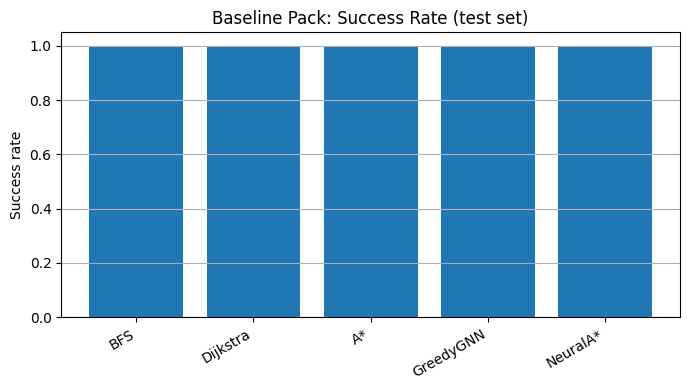

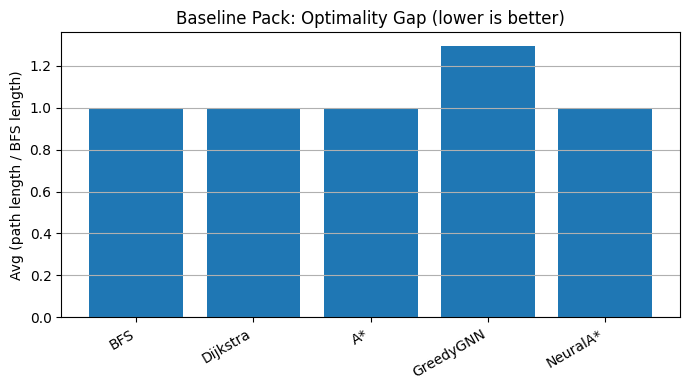

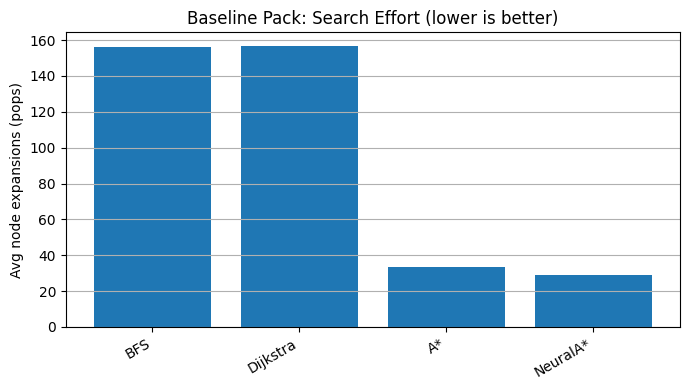

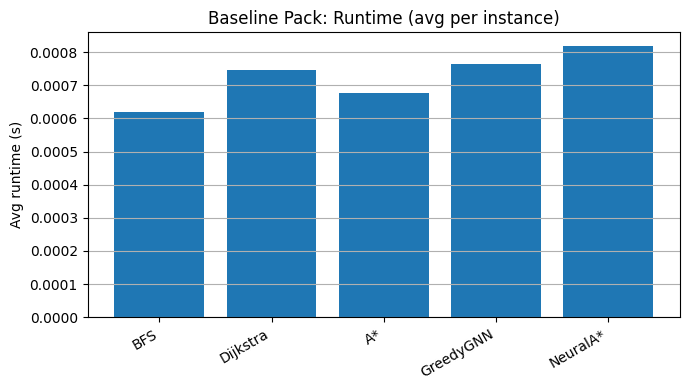

Saved charts to figures/: baseline_success.png, baseline_len_ratio.png, baseline_expansions.png, baseline_runtime.png


In [62]:
import matplotlib.pyplot as plt
import numpy as np

methods_order = ["BFS", "Dijkstra", "A*", "GreedyGNN", "NeuralA*"]

def get_arr(key):
    return [baseline_results[m].get(key, None) for m in methods_order]

# 1) Success rate bar
plt.figure(figsize=(7,4))
plt.bar(methods_order, get_arr("success_rate"))
plt.ylabel("Success rate")
plt.title("Baseline Pack: Success Rate (test set)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_success.png", dpi=200)
plt.show()

# 2) Path length ratio vs BFS (optimal) — where available
ratio = [baseline_results[m].get("len_ratio_vs_bfs_avg", None) for m in methods_order]
# BFS has no ratio; keep it as 1.0 for plotting
ratio = [1.0 if (m=="BFS") else ratio[i] for i,m in enumerate(methods_order)]

plt.figure(figsize=(7,4))
plt.bar(methods_order, ratio)
plt.ylabel("Avg (path length / BFS length)")
plt.title("Baseline Pack: Optimality Gap (lower is better)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_len_ratio.png", dpi=200)
plt.show()

# 3) Expansions (search effort) — only for BFS/Dijkstra/A*/NeuralA*
methods_order_2 = ["BFS", "Dijkstra", "A*", "NeuralA*"]

exp = [baseline_results[m].get("avg_expansions", None) for m in methods_order_2]
# Replace None with 0 for plotting
exp_plot = [0.0 if v is None else v for v in exp]

plt.figure(figsize=(7,4))
plt.bar(methods_order_2, exp_plot)
plt.ylabel("Avg node expansions (pops)")
plt.title("Baseline Pack: Search Effort (lower is better)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_expansions.png", dpi=200)
plt.show()

# 4) Runtime mean (seconds)
rt = [baseline_results[m].get("avg_time_s", None) for m in methods_order]
rt_plot = [0.0 if v is None else v for v in rt]

plt.figure(figsize=(7,4))
plt.bar(methods_order, rt_plot)
plt.ylabel("Avg runtime (s)")
plt.title("Baseline Pack: Runtime (avg per instance)")
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/baseline_runtime.png", dpi=200)
plt.show()

print("Saved charts to figures/: baseline_success.png, baseline_len_ratio.png, baseline_expansions.png, baseline_runtime.png")


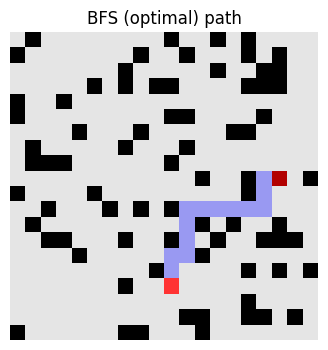

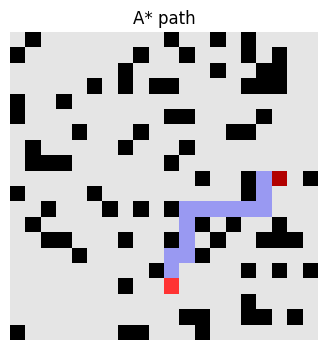

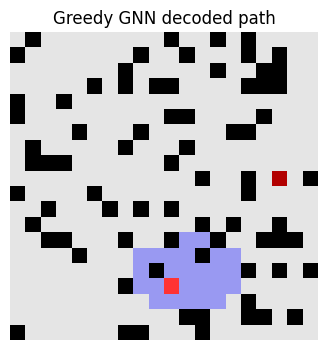

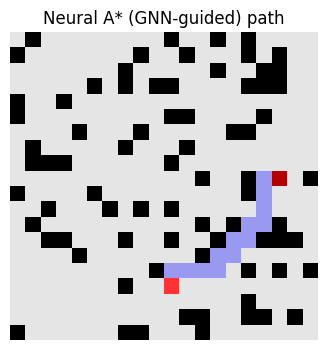

In [63]:
# Pick one example
example = test_data[0]
probs = predict_node_probs(example)

bfs_p, _ = bfs_path_graph(example)
a_p, _ = astar_path(example)
g_p = greedy_path(example, probs)
n_p, _ = neural_astar_path(example, probs, alpha=2.0)

plot_path_on_grid(example, bfs_p, title="BFS (optimal) path")
plot_path_on_grid(example, a_p, title="A* path")
plot_path_on_grid(example, g_p, title="Greedy GNN decoded path")
plot_path_on_grid(example, n_p, title="Neural A* (GNN-guided) path")


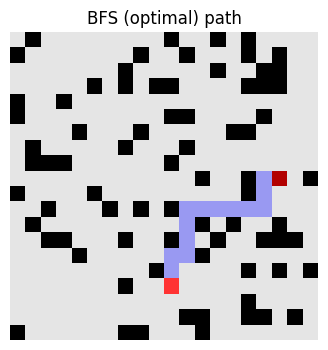

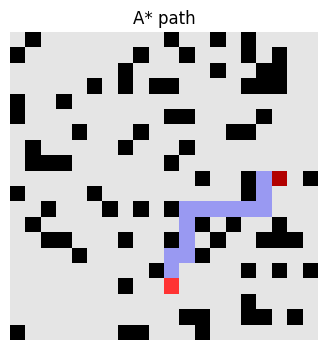

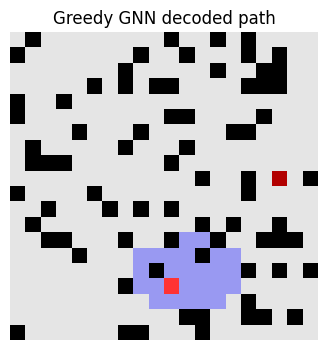

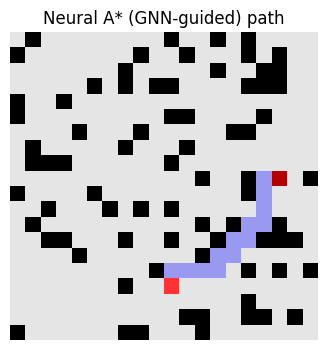

Saved qualitative path plots to figures/paths/:
 - figures/paths/paths_bfs_idx0.png
 - figures/paths/paths_astar_idx0.png
 - figures/paths/paths_greedy_idx0.png
 - figures/paths/paths_neural_idx0.png


In [64]:
# -------------------------------
# Save qualitative path plots (BFS / A* / GreedyGNN / NeuralA*)
# Put this near the end of the notebook (after training), after plot_path_on_grid is defined.
# -------------------------------
import os
import matplotlib.pyplot as plt

os.makedirs("figures/paths", exist_ok=True)

def save_path_plot(data, path, title, outpath):
    """Wrapper around your existing plot_path_on_grid that also saves the figure."""
    # draw
    plot_path_on_grid(data, path, title=title)
    # save the *current* figure created by matplotlib
    plt.tight_layout()
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close()

# Pick one test example (change index if you want)
idx = 0
example = test_data[idx]

# Compute paths
probs = predict_node_probs(example)

bfs_p, _ = bfs_path_graph(example)
a_p, _   = astar_path(example)
g_p      = greedy_path(example, probs)
n_p, _   = neural_astar_path(example, probs, alpha=2.0)

# Save images
save_path_plot(example, bfs_p, "BFS (optimal) path",         f"figures/paths/paths_bfs_idx{idx}.png")
save_path_plot(example, a_p,   "A* path",                    f"figures/paths/paths_astar_idx{idx}.png")
save_path_plot(example, g_p,   "Greedy GNN decoded path",    f"figures/paths/paths_greedy_idx{idx}.png")
save_path_plot(example, n_p,   "Neural A* (GNN-guided) path",f"figures/paths/paths_neural_idx{idx}.png")

print("Saved qualitative path plots to figures/paths/:")
print(f" - figures/paths/paths_bfs_idx{idx}.png")
print(f" - figures/paths/paths_astar_idx{idx}.png")
print(f" - figures/paths/paths_greedy_idx{idx}.png")
print(f" - figures/paths/paths_neural_idx{idx}.png")


scaling to 50x50

[OK] Registered baseline N=20 -> results/scaling/baseline_pack_N20.json

--- Scaling evaluation N=50 (target samples=300, p_block=0.2, alpha=2.0) ---
  [gen] attempt 1/6: got 199 new, total=199/300
  [gen] attempt 2/6: got 101 new, total=300/300
[OK] N=50 saved -> results/scaling/baseline_pack_N50.json | dataset size = 300
  A* avg expansions: 136.10 | NeuralA* avg expansions: 119.42

--- Scaling evaluation N=100 (target samples=150, p_block=0.2, alpha=2.0) ---
  [gen] attempt 1/6: got 148 new, total=148/150
  [gen] attempt 2/6: got 2 new, total=150/150
[OK] N=100 saved -> results/scaling/baseline_pack_N100.json | dataset size = 150
  A* avg expansions: 512.63 | NeuralA* avg expansions: 414.46

--- Scaling evaluation N=250 (target samples=60, p_block=0.2, alpha=2.0) ---
  [gen] attempt 1/6: got 60 new, total=60/60
[OK] N=250 saved -> results/scaling/baseline_pack_N250.json | dataset size = 60
  A* avg expansions: 2823.38 | NeuralA* avg expansions: 2542.35

Saved: results/scaling/scalin

,N,n_instances,A*_success,Neural_success,A*_gap_vs_BFS,Neural_gap_vs_BFS,A*_exp_avg,Neural_exp_avg,A*_exp_p95,Neural_exp_p95,A*_time_avg,Neural_time_avg,A*_time_p95,Neural_time_p95,exp_gap_abs,exp_gap_rel_%,exp_p95_gap_abs,exp_p95_gap_rel_%
0,20,177,1.0,1.0,1.0,1.0,33.581921,29.101695,100.40,80.60,0.000677,0.000819,0.001063,0.001418,4.480226,13.341184,19.80,19.721116
1,50,300,1.0,1.0,1.0,1.0,136.103333,119.423333,482.05,318.10,0.001310,0.001986,0.001954,0.003064,16.680000,12.255394,163.95,34.010995
2,100,150,1.0,1.0,1.0,1.0,512.633333,414.460000,1719.35,976.25,0.015863,0.017787,0.110585,0.108739,98.173333,19.150790,743.10,43.219821
3,250,60,1.0,1.0,1.0,1.0,2823.383333,2542.350000,11150.25,6208.80,0.138579,0.143650,0.259217,0.286240,281.033333,9.953779,4941.45,44.316944


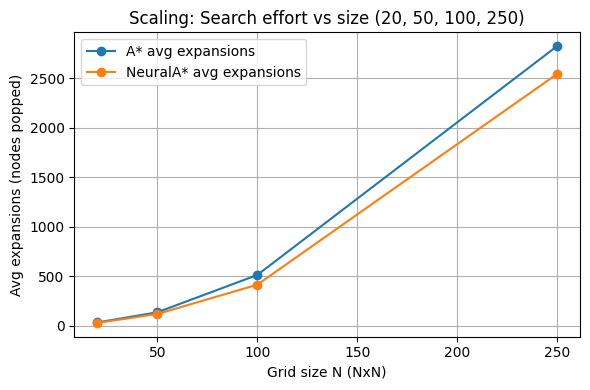

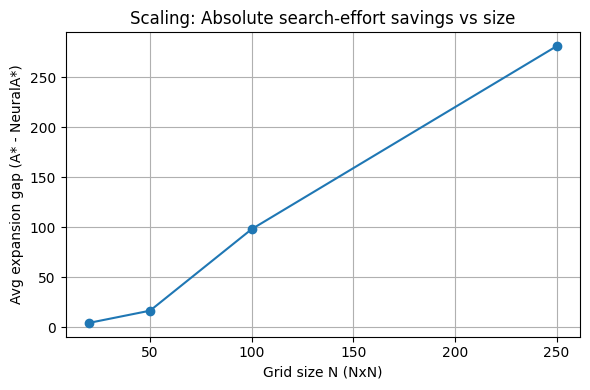

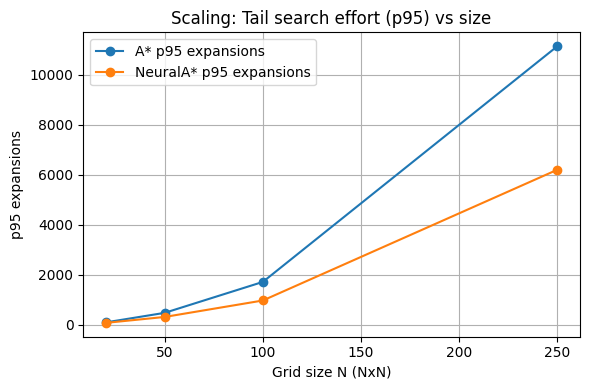

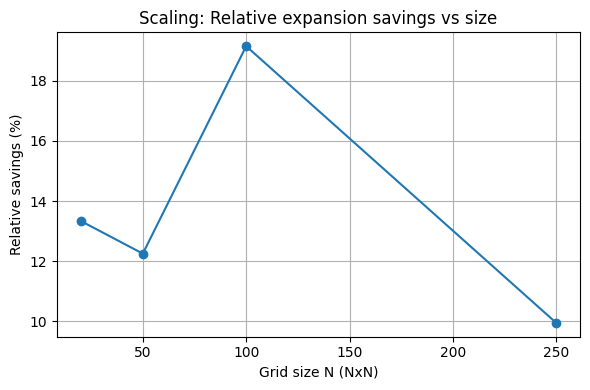

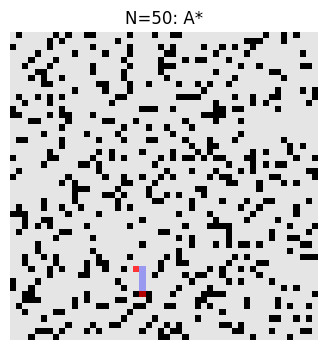

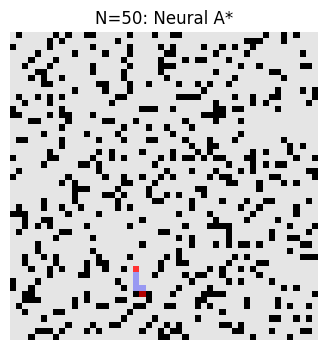

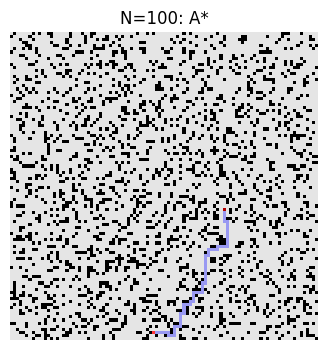

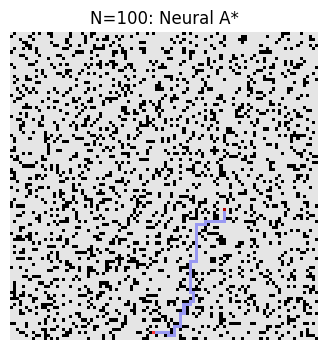

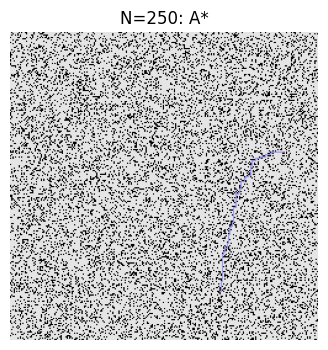

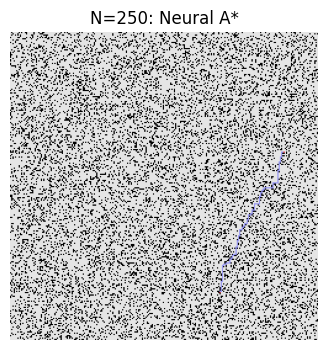

Saved qualitative examples to figures/scaling/qual/


In [68]:
# ============================================================
# SCALING EXPERIMENT: Include N=20 baseline + evaluate N=50, 100, 250
# Produces df_scale and plots showing how the search-effort gap scales.
# ============================================================

import os, json, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

os.makedirs("results/scaling", exist_ok=True)
os.makedirs("figures/scaling", exist_ok=True)
os.makedirs("figures/scaling/qual", exist_ok=True)

# ----------------------------
# Safety: ensure baseline_results exists for N=20
# ----------------------------
if "baseline_results" not in globals() or baseline_results is None:
    try:
        with open("results/baseline_pack.json", "r") as f:
            tmp = json.load(f)
        baseline_results = tmp["results"] if isinstance(tmp, dict) and "results" in tmp else tmp
        print("[OK] Loaded baseline_results from results/baseline_pack.json")
    except Exception as e:
        raise RuntimeError(
            "baseline_results not found in memory and could not load results/baseline_pack.json. "
            "Run the 20x20 baseline pack cell first."
        ) from e

# ----------------------------
# Config
# ----------------------------
N_train = RUN_INFO.get("grid_N", 20)  # expected 20
alpha = 2.0
p_block_test = 0.2
seed = 42

# Sizes to show in plots
scaling_sizes = [20, 50, 100, 250]

# Use fewer samples for larger N (especially 250)
num_samples_by_N = {
    50: 300,
    100: 150,
    250: 60,   # adjust up/down depending on runtime
}

# We'll store outputs here
scaling_outputs = {}   # per N: run_info + results + n_instances
scaling_datasets = {}  # per N: dataset (only for generated sizes)

# ----------------------------
# Optional: robust dataset generation wrapper (solvable-only)
# If your generate_dataset already internally handles attempts, you can ignore this.
# This wrapper retries by calling generate_dataset multiple times until enough samples
# or max_attempts reached.
# ----------------------------
def generate_dataset_with_attempts(target_n, p_block=0.2, max_attempts=6, chunk=200):
    """
    Calls generate_dataset in chunks to avoid infinite loops for solvable-only generation.
    Returns a list of Data objects (may be smaller than target_n if max_attempts reached).
    """
    data_list = []
    attempts = 0
    while len(data_list) < target_n and attempts < max_attempts:
        need = target_n - len(data_list)
        # generate in a chunk to keep it efficient
        n_req = max(min(chunk, need), 1)
        new_data = generate_dataset(num_samples=n_req, p_block=p_block)
        data_list.extend(new_data)
        attempts += 1
        print(f"  [gen] attempt {attempts}/{max_attempts}: got {len(new_data)} new, total={len(data_list)}/{target_n}")
        if len(new_data) == 0:
            break
    return data_list[:target_n]

# ----------------------------
# Helper: run evaluation at a given N
# ----------------------------
def run_scaling_eval(N_test, num_samples, p_block=0.2, alpha=2.0, seed=42, use_attempt_wrapper=True):
    global N
    N_prev = N
    N = N_test

    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    run_info = dict(RUN_INFO)
    run_info.update({
        "grid_N_train": N_train,
        "grid_N_test": N_test,
        "p_block_test": p_block,
        "alpha_test": alpha,
        "num_samples_requested": num_samples,
        "timestamp_utc_test": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
    })

    # Generate solvable-only dataset at this N
    if use_attempt_wrapper:
        dataset = generate_dataset_with_attempts(target_n=num_samples, p_block=p_block, max_attempts=6, chunk=200)
    else:
        dataset = generate_dataset(num_samples=num_samples, p_block=p_block)

    dataset = [d.to("cpu") for d in dataset]
    results = evaluate_baseline_pack(dataset, alpha=alpha)

    N = N_prev
    return run_info, results, dataset

# ----------------------------
# 1) Register N=20 baseline (use existing baseline_results)
# ----------------------------
scaling_outputs[20] = {
    "run_info": dict(RUN_INFO, grid_N_train=N_train, grid_N_test=20, alpha_test=alpha, p_block_test=RUN_INFO.get("p_block", None)),
    "results": baseline_results,
    "n_instances": len(test_data) if "test_data" in globals() else None
}
with open("results/scaling/baseline_pack_N20.json", "w") as f:
    json.dump(scaling_outputs[20], f, indent=2)
print("[OK] Registered baseline N=20 -> results/scaling/baseline_pack_N20.json")

# ----------------------------
# 2) Run N=50, 100, 250
# ----------------------------
for S in [50, 100, 250]:
    ns = num_samples_by_N[S]
    print(f"\n--- Scaling evaluation N={S} (target samples={ns}, p_block={p_block_test}, alpha={alpha}) ---")
    info_S, results_S, dataset_S = run_scaling_eval(
        N_test=S, num_samples=ns, p_block=p_block_test, alpha=alpha, seed=seed, use_attempt_wrapper=True
    )

    scaling_outputs[S] = {
        "run_info": info_S,
        "results": results_S,
        "n_instances": len(dataset_S)
    }
    scaling_datasets[S] = dataset_S

    out_json = f"results/scaling/baseline_pack_N{S}.json"
    with open(out_json, "w") as f:
        json.dump(scaling_outputs[S], f, indent=2)

    print(f"[OK] N={S} saved -> {out_json} | dataset size = {len(dataset_S)}")
    print(f"  A* avg expansions: {results_S['A*']['avg_expansions']:.2f} | NeuralA* avg expansions: {results_S['NeuralA*']['avg_expansions']:.2f}")

# ----------------------------
# 3) Build df_scale (N=20,50,100,250) with key metrics + gaps
# ----------------------------
def extract_row(S, pack):
    r = pack["results"]

    def safe_get(d, key, default=None):
        return d.get(key, default) if isinstance(d, dict) else default

    return {
        "N": S,
        "n_instances": pack.get("n_instances", None),

        "A*_success": safe_get(r["A*"], "success_rate"),
        "Neural_success": safe_get(r["NeuralA*"], "success_rate"),

        "A*_gap_vs_BFS": safe_get(r["A*"], "len_ratio_vs_bfs_avg"),
        "Neural_gap_vs_BFS": safe_get(r["NeuralA*"], "len_ratio_vs_bfs_avg"),

        "A*_exp_avg": safe_get(r["A*"], "avg_expansions"),
        "Neural_exp_avg": safe_get(r["NeuralA*"], "avg_expansions"),
        "A*_exp_p95": safe_get(r["A*"], "p95_expansions"),
        "Neural_exp_p95": safe_get(r["NeuralA*"], "p95_expansions"),

        "A*_time_avg": safe_get(r["A*"], "avg_time_s"),
        "Neural_time_avg": safe_get(r["NeuralA*"], "avg_time_s"),
        "A*_time_p95": safe_get(r["A*"], "p95_time_s"),
        "Neural_time_p95": safe_get(r["NeuralA*"], "p95_time_s"),
    }

rows = [extract_row(S, scaling_outputs[S]) for S in scaling_sizes]
df_scale = pd.DataFrame(rows).sort_values("N")

df_scale["exp_gap_abs"] = df_scale["A*_exp_avg"] - df_scale["Neural_exp_avg"]
df_scale["exp_gap_rel_%"] = 100.0 * df_scale["exp_gap_abs"] / df_scale["A*_exp_avg"]

df_scale["exp_p95_gap_abs"] = df_scale["A*_exp_p95"] - df_scale["Neural_exp_p95"]
df_scale["exp_p95_gap_rel_%"] = 100.0 * df_scale["exp_p95_gap_abs"] / df_scale["A*_exp_p95"]

df_scale.to_csv("results/scaling/scaling_table_N20_N50_N100_N250.csv", index=False)
print("\nSaved: results/scaling/scaling_table_N20_N50_N100_N250.csv")
display(df_scale)

# ----------------------------
# 4) Plots: show N=20,50,100,250 on same curves
# ----------------------------

# (A) expansions vs N
plt.figure(figsize=(6,4))
plt.plot(df_scale["N"], df_scale["A*_exp_avg"], marker="o", label="A* avg expansions")
plt.plot(df_scale["N"], df_scale["Neural_exp_avg"], marker="o", label="NeuralA* avg expansions")
plt.xlabel("Grid size N (NxN)")
plt.ylabel("Avg expansions (nodes popped)")
plt.title("Scaling: Search effort vs size (20, 50, 100, 250)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/scaling/expansions_vs_N_20_50_100_250.png", dpi=200)
plt.show()

# (B) absolute expansion gap vs N (main slide)
plt.figure(figsize=(6,4))
plt.plot(df_scale["N"], df_scale["exp_gap_abs"], marker="o")
plt.xlabel("Grid size N (NxN)")
plt.ylabel("Avg expansion gap (A* - NeuralA*)")
plt.title("Scaling: Absolute search-effort savings vs size")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/scaling/expansion_gap_abs_vs_N_20_50_100_250.png", dpi=200)
plt.show()

# (C) p95 expansions vs N (tail)
plt.figure(figsize=(6,4))
plt.plot(df_scale["N"], df_scale["A*_exp_p95"], marker="o", label="A* p95 expansions")
plt.plot(df_scale["N"], df_scale["Neural_exp_p95"], marker="o", label="NeuralA* p95 expansions")
plt.xlabel("Grid size N (NxN)")
plt.ylabel("p95 expansions")
plt.title("Scaling: Tail search effort (p95) vs size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/scaling/expansions_p95_vs_N_20_50_100_250.png", dpi=200)
plt.show()

# (D) relative savings (%)
plt.figure(figsize=(6,4))
plt.plot(df_scale["N"], df_scale["exp_gap_rel_%"], marker="o")
plt.xlabel("Grid size N (NxN)")
plt.ylabel("Relative savings (%)")
plt.title("Scaling: Relative expansion savings vs size")
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/scaling/expansion_gap_rel_vs_N_20_50_100_250.png", dpi=200)
plt.show()

# ----------------------------
# 5) Qualitative examples for N=50,100,250 (optional)
# Requires save_path_plot() helper.
# ----------------------------
if "save_path_plot" in globals():
    for S in [50, 100, 250]:
        if S not in scaling_datasets or len(scaling_datasets[S]) == 0:
            print(f"[Skip] No dataset saved for N={S}.")
            continue

        N_prev = N
        N = S

        ex = scaling_datasets[S][0]
        probs = predict_node_probs(ex)

        a_p, _ = astar_path(ex)
        n_p, _ = neural_astar_path(ex, probs, alpha=alpha)

        save_path_plot(ex, a_p, f"N={S}: A*", f"figures/scaling/qual/N{S}_astar.png")
        save_path_plot(ex, n_p, f"N={S}: Neural A*", f"figures/scaling/qual/N{S}_neural_astar.png")

        N = N_prev

    print("Saved qualitative examples to figures/scaling/qual/")
else:
    print("[Note] save_path_plot() not found; skipping qualitative image export.")



In [69]:
import json, pandas as pd

sizes = [20, 50, 100, 250]
rows = []

for S in sizes:
    with open(f"results/scaling/baseline_pack_N{S}.json", "r") as f:
        pack = json.load(f)
    r = pack["results"]

    rows.append({
        "N": S,
        "n_instances": pack.get("n_instances"),
        "A*_success": r["A*"]["success_rate"],
        "Neural_success": r["NeuralA*"]["success_rate"],
        "A*_exp_avg": r["A*"]["avg_expansions"],
        "Neural_exp_avg": r["NeuralA*"]["avg_expansions"],
        "A*_exp_p95": r["A*"]["p95_expansions"],
        "Neural_exp_p95": r["NeuralA*"]["p95_expansions"],
        "A*_time_avg": r["A*"]["avg_time_s"],
        "Neural_time_avg": r["NeuralA*"]["avg_time_s"],
    })

df_scale = pd.DataFrame(rows).sort_values("N")
df_scale["exp_gap_abs"] = df_scale["A*_exp_avg"] - df_scale["Neural_exp_avg"]
df_scale["exp_gap_rel_%"] = 100 * df_scale["exp_gap_abs"] / df_scale["A*_exp_avg"]

print(df_scale.to_string(index=False))


  N  n_instances  A*_success  Neural_success  A*_exp_avg  Neural_exp_avg  A*_exp_p95  Neural_exp_p95  A*_time_avg  Neural_time_avg  exp_gap_abs  exp_gap_rel_%
 20          177         1.0             1.0   33.581921       29.101695      100.40           80.60     0.000677         0.000819     4.480226      13.341184
 50          300         1.0             1.0  136.103333      119.423333      482.05          318.10     0.001310         0.001986    16.680000      12.255394
100          150         1.0             1.0  512.633333      414.460000     1719.35          976.25     0.015863         0.017787    98.173333      19.150790
250           60         1.0             1.0 2823.383333     2542.350000    11150.25         6208.80     0.138579         0.143650   281.033333       9.953779
